# Bootstrapped Regression Coefficients

Here we explore the theoretical coefficient distributions from a linear regression model. When fitting a regression model we can get estimates for the standard deviation of the coefficients. We use bootstrapping to get an empiracle distribution of the regression coefficients to compare against those distributions.

The outline is as follows:
* Collect some data
* Fit a regression model
* Fit many models on bootstrapped samples of the training data
* Compare the distribution of bootstrapped coefficients to the theoretical distribution of coefficients


The data used is weather data collect from kaggle:
[https://www.kaggle.com/budincsevity/szeged-weather](https://www.kaggle.com/budincsevity/szeged-weather)

In [1]:
import os
import pandas as pd
import numpy as np

dir_path = os.getcwd()
data = pd.read_csv(os.path.join(dir_path, "data", "weatherHistory.csv"))
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Next we do some data preparation. We create a model to predict apparent temperature using most of the remaining columns:

In [2]:
# Calculate apprent temperature
X = data.loc[:, ['Temperature (C)',
       'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)']]
X = X.join(pd.get_dummies(data['Precip Type']))

# add constant column
X['Constant'] = 1

y = data.loc[:, 'Apparent Temperature (C)']

X.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),rain,snow,Constant
0,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13,1,0,1
1,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63,1,0,1
2,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,1,0,1
3,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41,1,0,1
4,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51,1,0,1


We reduce the training data size just to enlarge the coefficient distributino for the purpose of this article.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_train.shape

(9645, 10)

## Statsmodels approach

With `statsmodels` we can apply the ordinary least squares solution to the above data to recover estimates of the model coefficients. When we fit a linear regression model the Hessian (2nd order derivatives) determines how sensitive the coefficients are to changes in the data. This in turn is used to calculate the standard deviation of the coefficients.

In [4]:
import statsmodels.api as sm

results = sm.OLS(y_train, X_train).fit()
print(results.summary())
# extract coefficient distributions
w_sm_mu = results.params
w_sm_std = np.sqrt(np.diag(results.normalized_cov_params))

OLS Regression Results                               
Dep. Variable:     Apparent Temperature (C)   R-squared:                       0.990
Model:                                  OLS   Adj. R-squared:                  0.990
Method:                       Least Squares   F-statistic:                 1.175e+05
Date:                      Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                              00:00:29   Log-Likelihood:                -14401.
No. Observations:                      9645   AIC:                         2.882e+04
Df Residuals:                          9636   BIC:                         2.888e+04
Df Model:                                 8                                         
Covariance Type:                  nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

The above model coefficients suggest that the apparent temperature is mostly made up of the actual temperature. Humidity has a positive relationship and wind a negative relationship.

## Bootstrapping approach

To get an empirical idea of the distribution of the regression coefficients we can refit the model on many bootstrapped samples. A bootstrap sample is when we take random samples from our training set, with replacement. If we take 1000 bootstrap samples and fit a model on each we gain 1000 estimates of the regression coefficients.

We do this as follows:

In [5]:
w_bs = []
n = X_train.shape[0]
for i in range(1000):
    samp = np.random.randint(n, size=n)
    results_bs = sm.OLS(y_train.loc[samp], X_train.loc[samp,:]).fit()
    w_bs.append(results_bs.params)
w_bs = np.array(w_bs)

# summarise coefficient distributions
w_bs_mu = np.mean(w_bs, axis=0)
w_bs_std = np.std(w_bs, axis=0)

## Results comparison
We can now compare the coefficient distributions to the theoretical results from statsmodels.

Below we plot the coefficient means and standard deviations from both statsmodels and the bootstrapped models.

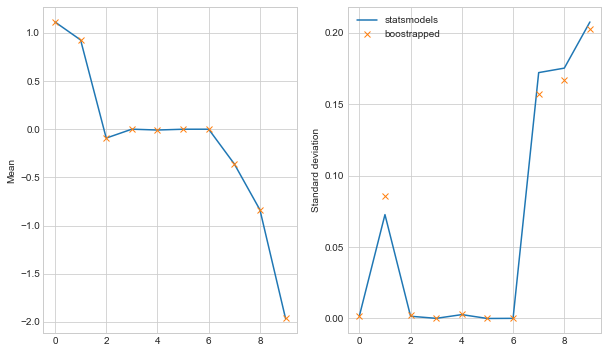

In [6]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

fig, ax = plt.subplots(ncols=2, figsize=(10,6))
ax[0].plot(range(X.shape[1]), w_sm_mu, label='statsmodels')
ax[0].plot(range(X.shape[1]), w_bs_mu, 'x', label='boostrapped')
ax[0].set_ylabel('Mean')

ax[1].plot(range(X.shape[1]), w_sm_std, label='statsmodels')
ax[1].plot(range(X.shape[1]), w_bs_std, 'x', label='boostrapped')
ax[1].set_ylabel('Standard deviation')

plt.legend()
plt.show()

The above figures show that both the means and standard deviations are close. This suggests the coefficient distribution from the theory are likely correct. The numbers should converge with more bootstrap samples.


I would expect the bootstrapped coefficients to maybe over estimate the coefficient standard deviations - each bootstrap sample will have fewer unique data entries to fit the model, as such the coefficients may not be as tightly fit. It doesn't seem like we have enough evidence to clarify this.

The raw result numbers are shown below:

In [7]:
coefficients = pd.concat([w_sm_mu,
                        pd.DataFrame(data=w_bs_mu, index=X_train.columns),
                        pd.DataFrame(data=w_sm_std, index=X_train.columns),
                        pd.DataFrame(data=w_bs_std, index=X_train.columns)], axis=1)

coefficients.columns = ['statsmodels_mu', 'bootstrapped_mu', 'statsmodels_std', 'bootstrapped_std']
coefficients

,statsmodels_mu,bootstrapped_mu,statsmodels_std,bootstrapped_std
Temperature (C),1.113766e+00,1.113721e+00,1.702782e-03,1.919617e-03
Humidity,9.269036e-01,9.255212e-01,7.272990e-02,8.587625e-02
Wind Speed (km/h),-9.193476e-02,-9.207228e-02,1.560984e-03,2.599598e-03
Wind Bearing (degrees),5.787597e-04,5.797346e-04,9.620203e-05,1.074969e-04
Visibility (km),-8.162228e-03,-8.096304e-03,2.701086e-03,2.871113e-03
Loud Cover,2.722203e-15,2.385971e-17,1.432384e-15,2.841603e-15
Pressure (millibars),2.355312e-04,2.313375e-04,8.573335e-05,9.545615e-05
rain,-3.603448e-01,-3.645398e-01,1.721736e-01,1.573641e-01
snow,-8.370791e-01,-8.412777e-01,1.753044e-01,1.671947e-01
Constant,-1.964852e+00,-1.954745e+00,2.076308e-01,2.028931e-01
